In [1]:
import sys
sys.path.append('/workspace/MRI-inpainting-project/data_scripts') # path to datasets.py dir

from datasets import TrainPatchesDataset, HealthyMRIDataset, PathologicalMRIDataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [4]:
train_patches = TrainPatchesDataset("/workspace/MRI-inpainting-project/data/train_patches_v3")
healthy_data = HealthyMRIDataset('/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_mri_t1',
                                 '/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_masks_t1/sphere_masks/masks',
                                 '/workspace/MRI-inpainting-project/data/healthy_mri_C_00/healthy_masks_t1/sphere_masks/patch_masks')

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Input channels: noise (1) + condition image (1) = 2
        self.main = nn.Sequential(
            # Encoder part
            nn.Conv3d(2, 64, kernel_size=4, stride=2, padding=1),  # Output: [64, 20, 20, 20]
            nn.BatchNorm3d(64),
            nn.ReLU(True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: [128, 10, 10, 10]
            nn.BatchNorm3d(128),
            nn.ReLU(True),
            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: [256, 5, 5, 5]
            nn.BatchNorm3d(256),
            nn.ReLU(True),
            # Decoder part
            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: [128, 10, 10, 10]
            nn.BatchNorm3d(128),
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: [64, 20, 20, 20]
            nn.BatchNorm3d(64),
            nn.ReLU(True),
            nn.ConvTranspose3d(64, 1, kernel_size=4, stride=2, padding=1),  # Output: [1, 40, 40, 40]
            nn.Sigmoid()  
        )
        
    def forward(self, noise, condition):
        x = torch.cat([noise, condition], dim=1) 
        mask = self.main(x)
        return mask  

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv3d(1, 4, kernel_size=4, stride=2, padding=1),  # Output: [64, 20, 20, 20]
            nn.BatchNorm3d(4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(4, 4, kernel_size=4, stride=2, padding=1),  # Output: [128, 10, 10, 10]
            nn.BatchNorm3d(4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(4, 4, kernel_size=4, stride=2, padding=1),  # Output: [256, 5, 5, 5]
            nn.BatchNorm3d(4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(4, 1, kernel_size=5),  # Output: [1, 1, 1, 1]
            nn.Sigmoid()  
        )
        
    def forward(self, masked_image):
        output = self.main(masked_image)
        return output.view(-1) 


class MRI3DDataset(Dataset):
    def __init__(self, num_samples, image_shape):
        self.num_samples = num_samples
        self.image_shape = image_shape
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):

        mri = healthy_data[idx]['mri']
        patch_mask = healthy_data[idx]['patch_mask']

        condition_image = torch.from_numpy(mri[patch_mask > 0].reshape(40, 40, 40)).unsqueeze(0).float()
        real_masked_image = torch.from_numpy(train_patches[idx]['patch'] * (1-train_patches[idx]['mask'])).unsqueeze(0).float()

        
        return {'condition_image': condition_image, 'real_masked_image': real_masked_image}


num_epochs = 5
batch_size = 4  
image_shape = (40, 40, 40)  
noise_shape = (1, *image_shape)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(D.parameters(), lr=0.0002)
optimizerG = optim.Adam(G.parameters(), lr=0.0002)

dataset = MRI3DDataset(num_samples=77, image_shape=image_shape)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        ############################
        # Update Discriminator
        ############################
        D.zero_grad()
        
        condition_image = data['condition_image'].to(device)  
        real_masked_image = data['real_masked_image'].to(device)
        batch_size = condition_image.size(0)
        real_labels = torch.ones(batch_size, device=device)
        
        output = D(real_masked_image)
        lossD_real = criterion(output, real_labels)

        if i % 3 == 0:
            lossD_real.backward()
        
        noise = torch.randn(batch_size, *noise_shape, device=device)
        fake_mask = G(noise, condition_image)
        fake_masked_image = condition_image * (1 - (fake_mask > 0.5).float())
        fake_labels = torch.zeros(batch_size, device=device)
        
        output = D(fake_masked_image.detach())
        lossD_fake = criterion(output, fake_labels)

        if i % 3 == 0:
            lossD_fake.backward()
            optimizerD.step()
        
        ############################
        # Update Generator
        ############################
        G.zero_grad()
        output = D(fake_masked_image)
        
        lossG = criterion(output, real_labels)
        lossG.backward()
        optimizerG.step()
        
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                  f"Loss D: {(lossD_real + lossD_fake).item():.4f}, Loss G: {lossG.item():.4f}")

print("Training finished.")

Epoch [1/5], Step [0/20], Loss D: 1.3914, Loss G: 0.7639
Epoch [1/5], Step [10/20], Loss D: 1.2631, Loss G: 0.6328
Epoch [2/5], Step [0/20], Loss D: 1.2852, Loss G: 0.7212
Epoch [2/5], Step [10/20], Loss D: 1.2383, Loss G: 0.8354
Epoch [3/5], Step [0/20], Loss D: 1.0589, Loss G: 0.8707
Epoch [3/5], Step [10/20], Loss D: 1.1100, Loss G: 0.7930
Epoch [4/5], Step [0/20], Loss D: 0.9770, Loss G: 1.0188
Epoch [4/5], Step [10/20], Loss D: 0.8715, Loss G: 0.9529
Epoch [5/5], Step [0/20], Loss D: 0.7503, Loss G: 1.1693
Epoch [5/5], Step [10/20], Loss D: 0.6600, Loss G: 1.2262
Training finished.


## Generating mask example

In [6]:
idx = 0
mri, mask, patch_mask = healthy_data[idx]['mri'], healthy_data[idx]['mask'], healthy_data[idx]['patch_mask']
patch = torch.from_numpy(mri[patch_mask > 0].reshape(40, 40, 40)).float().unsqueeze(0).unsqueeze(0).to(device)

In [8]:
G.eval()
noise = torch.randn(1, *noise_shape, device=device)
fake_mask = G(noise, patch)

In [9]:
fake_mask = fake_mask.to('cpu').detach().numpy()

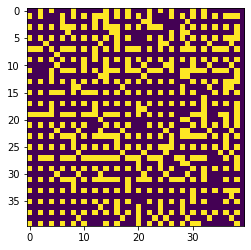

In [10]:
plt.imshow(fake_mask.squeeze()[:, :, 0] > 0.5)